# Facies Classification Solution By Team_BGC

Cheolkyun Jeong and Ping Zhang From Team_BGC

## Import Header

In [1]:
##### import basic function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
##### import stuff from scikit learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, recall_score, precision_score

## 1. Data Prepocessing

1) Filtered data preparation

After the initial data validation, we figure out the NM_M input is a key differentiator to group non-marine stones (sandstone, c_siltstone, and f_siltstone) and marine stones (marine_silt_shale, mudstone, wakestone, dolomite, packstone, and bafflestone) in the current field. Our team decides to use this classifier aggressively and prepare a filtered dataset which cleans up the outliers.

In [2]:
# Input file paths
facies_vector_path = 'facies_vectors.csv'
train_path = 'training_data.csv'
test_path = 'validation_data_nofacies.csv'
# Read training data to dataframe
#training_data = pd.read_csv(train_path)

Using Full data to train

In [3]:
# 1=sandstone  2=c_siltstone   3=f_siltstone # 4=marine_silt_shale 
#5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors

In [4]:
training_data = pd.read_csv(facies_vector_path)
X = training_data[feature_names].values
y = training_data['Facies'].values
well = training_data['Well Name'].values
depth = training_data['Depth'].values

In [5]:
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

# Fitering out some outliers
j = []
for i in range(len(training_data)):
    if ((training_data['NM_M'].values[i]==2)and ((training_data['Facies'].values[i]==1)or(training_data['Facies'].values[i]==2)or(training_data['Facies'].values[i]==3))):
        j.append(i)
    elif((training_data['NM_M'].values[i]==1)and((training_data['Facies'].values[i]!=1)and(training_data['Facies'].values[i]!=2)and(training_data['Facies'].values[i]!=3))):
        j.append(i)

training_data_filtered = training_data.drop(training_data.index[j])
print(np.shape(training_data_filtered))

(4095, 12)


//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Add Missing PE by following AR4 Team

In [6]:
#X = training_data_filtered[feature_names].values
# Testing without filtering
X = training_data[feature_names].values

reg = RandomForestRegressor(max_features='sqrt', n_estimators=50)
# DataImpAll = training_data_filtered[feature_names].copy()
DataImpAll = training_data[feature_names].copy()
DataImp = DataImpAll.dropna(axis = 0, inplace=False)
Ximp=DataImp.loc[:, DataImp.columns != 'PE']
Yimp=DataImp.loc[:, 'PE']
reg.fit(Ximp, Yimp)
X[np.array(DataImpAll.PE.isnull()),4] = reg.predict(DataImpAll.loc[DataImpAll.PE.isnull(),:].drop('PE',axis=1,inplace=False))

## 2. Feature Selection

Log Plot of Facies

### Filtered Data

SS      268
CSiS    940
FSiS    780
SiSh    271
MS      296
WS      582
D       141
PS      686
BS      185
Name: Facies, dtype: int64

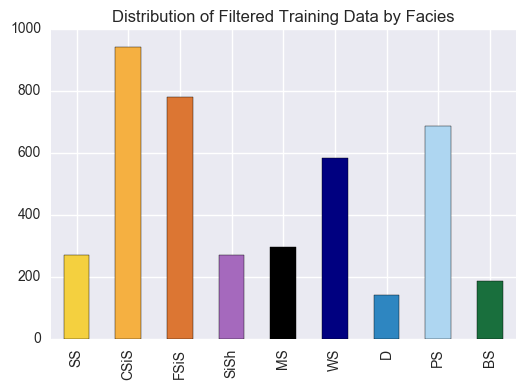

In [7]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
#facies_counts_filtered = training_data_filtered['Facies'].value_counts().sort_index()
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
#facies_counts_filtered.index = facies_labels
facies_counts.index = facies_labels

#facies_counts_filtered.plot(kind='bar',color=facies_colors, 
#                   title='Distribution of Filtered Training Data by Facies')
facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Filtered Training Data by Facies')
#facies_counts_filtered
#training_data_filtered.columns
#facies_counts_filtered

training_data.columns
facies_counts

### Filtered facies

In [8]:
correct_facies_labels = training_data['Facies'].values
feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)

Normailization

In [9]:
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
scaler = preprocessing.StandardScaler().fit(X)
scaled_features = scaler.transform(X)

## 3. Prediction Model

Accuracy

In [10]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [11]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

Augment Features

In [12]:
# HouMath Team algorithm
# Feature windows concatenation function 

def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug

In [13]:
# HouMath Team algorithm
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

In [14]:
# HouMath Team algorithm
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [15]:
X_aug, padded_rows = augment_features(scaled_features, well, depth)
X_aug.shape

(4149, 28)

In [16]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_aug, y, test_size=0.3, random_state=16)
X_train_full, X_test_zero, y_train_full, y_test_full = train_test_split(X_aug, y, test_size=0.0, random_state=42)
X_train_full.shape

(4149, 28)

SVM

In [17]:
from classification_utilities import display_cm, display_adj_cm
import sklearn.svm as svm

In [18]:
clf_filtered = svm.SVC(C=10, gamma=1)
clf_filtered.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
#predicted_labels_filtered = clf_filtered.predict(X_test_filtered)
predicted_labels = clf_filtered.predict(X_test)
cv_conf_svm = confusion_matrix(y_test, predicted_labels)
print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf_svm))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf_svm, adjacent_facies))
display_cm(cv_conf_svm, facies_labels,display_metrics=True, hide_zeros=True)

Optimized facies classification accuracy = 0.66
Optimized adjacent facies classification accuracy = 0.83
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    63    19     9           1                            92
     CSiS     3   198    92                                       293
     FSiS          25   199           1                 1         226
     SiSh                22    45     1     4           4          76
       MS                30     3    25    12     1    13          84
       WS                43     2     5   104          38         192
        D                19     1     1     3    11     5     1    41
       PS                47                 7         139     1   194
       BS                10     1                       3    33    47

Precision  0.95  0.82  0.42  0.87  0.74  0.80  0.92  0.68  0.94  0.74
   Recall  0.68  0.68  0.88  0.59  0.30  0.54  0.27  0.72  0.70  0.66
       F1  0.80  0.74  0.57  0.70  0.42  0.6

## 4. Result Analysis

Prepare test data

In [20]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)
# Prepare test data
well_ts = well_data['Well Name'].values
depth_ts = well_data['Depth'].values
X_ts = well_data[feature_names].values
X_ts = scaler.transform(X_ts)
# Augment features
X_ts, padded_rows = augment_features(X_ts, well_ts, depth_ts)

In [21]:
# Using all data and optimize parameter to train the data
clf_filtered = svm.SVC(C=10, gamma=1)
clf_filtered.fit(X_train_full, y_train_full)
#clf_filtered.fit(X_train_filtered, y_train_filtered)
y_pred = clf_filtered.predict(X_ts)
well_data['Facies'] = y_pred
well_data
well_data.to_csv('predict_result_svm_full_data.csv')

## 5. Using Tensorflow

Filtered Data Model

In [22]:
X_train.shape

(2904, 28)

In [98]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf

# Specify that all features have real-value data
# feature_columns_filtered = [tf.contrib.layers.real_valued_column("", dimension=7)]
feature_columns_filtered = [tf.contrib.layers.real_valued_column("", dimension=28)]

# Build DNN 
classifier_filtered = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns_filtered,
                                            hidden_units=[14, 28, 10],
                                            n_classes=10)

classifier_filtered.fit(x=X_train,y=y_train,steps=5000)
y_predict = []
predictions = classifier_filtered.predict(x=X_test)


for i, p in enumerate(predictions):
    y_predict.append(p)
    #print("Index %s: Prediction - %s, Real - %s" % (i + 1, p, y_test_filtered[i]))

# Evaluate accuracy.
accuracy_score = classifier_filtered.evaluate(x=X_test, y=y_test)["accuracy"]
print('Accuracy: {0:f}'.format(accuracy_score))

cv_conf_dnn = confusion_matrix(y_test, y_predict)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf_dnn))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf_dnn, adjacent_facies))
display_cm(cv_conf_dnn, facies_labels,display_metrics=True, hide_zeros=True)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'keep_checkpoint_every_n_hours': 10000, 'tf_random_seed': None, 'keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_is_chief': True, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_environment': 'local', '_master': '', '_task_type': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1277612b0>, 'save_checkpoints_steps': None, 'save_checkpoints_secs': 600, '_evaluation_master': '', '_task_id': 0, 'save_summary_steps': 100}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_si

Result from DNN

In [99]:
classifier_filtered.fit(x=X_train_full,
               y=y_train_full,
               steps=10000)
predictions = classifier_filtered.predict(X_ts)
y_predict_filtered = []
for i, p in enumerate(predictions):
    y_predict_filtered.append(p)
well_data['Facies'] = y_predict_filtered
well_data
well_data.to_csv('predict_result_dnn_full_data.csv')

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Summary name dnn/hiddenlayer_0:fraction_of_zero_values is illegal; using

Post Processing

In [100]:
well_data["Well Name"].value_counts()
idx_s = []
idx_c = []
for i in range(len(well_data)):
    if (well_data["Well Name"].values[i] == "STUART"):
        idx_s.append(i)
    else:
        idx_c.append(i)
well_s = well_data.drop(well_data.index[idx_c])
well_c = well_data.drop(well_data.index[idx_s])

In [101]:
def smooth_results(w_data):
    data = w_data.copy()
    first_face = 0
    next_face = 0
    face_len = 0
    last_face = 0
    for i in range(len(data)):
        if(i==0):
            first_face = data["Facies"].values[i]
            continue
        next_face = data["Facies"].values[i]
        if (first_face == next_face):
            face_len = face_len+1
        if (face_len >=4):
            last_face = first_face
        if (first_face != next_face):
            if(last_face == next_face) and (face_len <4):
                for j in range(i-face_len, i):
                    data["Facies"].values[j]=last_face
                face_len = 1
            else:
                face_len = 1
                first_face = next_face
    return data

In [102]:
well_s_s = smooth_results(well_s)
well_c_s = smooth_results(well_c)

In [103]:
smooth_result = well_s_s
smooth_result = smooth_result.append(well_c_s)
smooth_result.to_csv('predict_result_svm_full_data_smooth.csv')

Find best model by setting different parameters

In [29]:
def dnn_prediction(dnn,s_num):
    dnn.fit(x=X_train,y=y_train,steps=s_num)
    y_predict = []
    predictions = classifier_filtered.predict(x=X_test)

    for i, p in enumerate(predictions):
        y_predict.append(p)

    score = classifier_filtered.evaluate(x=X_test, y=y_test)["accuracy"]
    print('Accuracy: {0:f}'.format(accuracy_score))

    cv_conf = confusion_matrix(y_test, y_predict)
    return score, cv_conf